In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cftime
from xhistogram.xarray import histogram
import scipy.stats

In [3]:
import sys
sys.path.append('/Users/u6955431/PhD/ensemble-analogue-predictability/')
import predictability_tools as pt

## ORAS5 data

In [3]:
# Fetch ORAS5 observational data
sst_path = '/Users/u6955431/Large_Datasets/ORAS5/oras5/regridded_ORCA025/sosstsst/opa0/*/*.nc'
ssh_path = '/Users/u6955431/Large_Datasets/ORAS5/oras5/regridded_ORCA025/sossheig/opa0/*/*.nc'
T_AREA = xr.load_dataset('/Users/u6955431/Large_Datasets/pi_sst/b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.SST.000101-009912.nc').TAREA

#Read in SST, strip climatology
sst = xr.open_mfdataset(sst_path).sosstsst.load()
sst = pt.declim(sst,'time_counter')

#Read in SSH, strip global mean because Boussinesq models
raw_ssh = xr.open_mfdataset(ssh_path).sossheig.load()
global_mean_ssh = ((raw_ssh*T_AREA)/T_AREA.sum(('nlon','nlat'))).sum(('nlon','nlat'))
ssh = raw_ssh-global_mean_ssh
ssh = pt.declim(ssh,'time_counter')
ssh = ssh.sel(time_counter = sst.time_counter) #No clue why ssh goes back further than SST, but okay

#Combine the two of these
ss = xr.concat((sst,ssh),'var').assign_coords(var=np.array(('sst','ssh'))).rename('ss')
ss = ss.assign_coords({'TLONG':T_AREA.TLONG,'TLAT':T_AREA.TLAT}).reset_coords(('ULAT','ULONG'),drop=True)
ss_std = ss.std(('nlon','nlat','time_counter'))

In [6]:
eof_ready_data = pt.prepare_for_eof(ss,time_dims=('time_counter',))
obs_eof = pt.calculate_eof(eof_ready_data,50,keep_coords=('TLONG','TLAT'))

In [7]:
obs_pca = obs_eof.pca

## Model data

In [8]:
%%time

try:              ### DO NOT TRY TO RUN THIS CELL WITH A DASK CLUSTER! I mean it.
    client.close()# it takes for ever, uses way too much memory and then kills the kernel
except:
    pass

model_sst = pt.correct_cesm_date(xr.open_mfdataset('/Users/u6955431/Large_Datasets/CESM2_PI_SST/*.nc').SST)
model_ssh = pt.correct_cesm_date(xr.open_mfdataset('/Users/u6955431/Large_Datasets/CESM2_PI_SSH/*.nc').SSH)/100 # centimetres 🤬

model_ss = xr.concat((model_sst,model_ssh),'var').assign_coords(var=np.array(('sst','ssh')))

model_ss = pt.declim(model_ss)
model_ss = model_ss.drop('z_t')

model_ss = pt.trim_to_eof(model_ss,obs_eof.eof)
_=model_ss.load()

/Users/u6955431/mambaforge/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 2000 times more chunks
  return self.array[key]


CPU times: user 2min 25s, sys: 27.7 s, total: 2min 52s
Wall time: 2min 6s


In [9]:
%%time
model_pca = pt.project_onto_eof(model_ss.squeeze()/obs_eof.scaling,obs_eof.eof,space_dims = ('nlon','nlat','var'),time_dims=('time',))
_=model_pca.load()

/Users/u6955431/PhD/ensemble-analogue-predictability/predictability_tools/eofs.py:144: UserWarning: Replacing nans with 0 before linear algebra. You ought to deal with them earlier though...
  warnings.warn('Replacing nans with 0 before linear algebra. You ought to deal with them earlier though...')


CPU times: user 9.39 s, sys: 5.22 s, total: 14.6 s
Wall time: 10.2 s


## Suppose we want two nearly identical examples

In [15]:
shared_args={'init_month': 5,
             'lead_times': np.array((0,6)),
             'archive': model_pca.isel(time=slice(700,None)),
             'time_dim':'time',
             'n_members':15,
             'mode_slice':slice(None,None)}

In [13]:
def double_ensemble_wrapper(truth,archive,init_month,lead_times,time_dim,n_members,mode_slice):
    
    
    init_i = np.where(truth[time_dim+'.month']==init_month)[0]
    init_i = init_i[(init_i>=np.min(lead_times)) & (init_i<truth[time_dim].shape[0]-np.max(lead_times))]

    truth_ens = pt.pseudo_ensemble(init_i,
                                truth,
                                lead_times).rename(M='Y').rename(time='pred_time')
    
    ens = pt.analogue_ensemble(truth_ens.isel(L=0),
                    archive, 
                    obs_eof.variance_fraction, 
                    n_members,
                    initial_month = init_month,
                    lead_times = lead_times,
                    mode_slice = mode_slice,
                   )
    ens = ens.assign_coords({'pred_time':truth_ens.pred_time})
    
    return truth_ens,ens

## Observational example

In [20]:
truth_ens,ens = double_ensemble_wrapper(obs_pca,**shared_args)

#### Full regional skill

In [21]:
regional_skill = pt.R2(pt.trim_to_eof(ss.sel(time_counter=truth_ens.pred_time.sel(L=6),var='sst'),obs_eof.eof,trim_dim=('nlon','nlat')),
                       model_ss.sel(time=ens.time.sel(L=6),var='sst').mean('M').squeeze()).load()

(-10.0, 10.0)

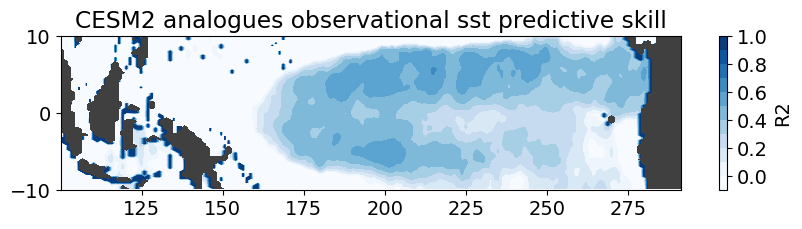

In [22]:
plt.figure(figsize=(10,2))
plt.contourf(regional_skill.TLONG,regional_skill.TLAT,np.isnan(regional_skill).astype(float),
             cmap='Greys',levels=(0.1,1.1),vmax=1.5,vmin=-3)
plt.contourf(regional_skill.TLONG,regional_skill.TLAT,regional_skill,
             levels=np.concatenate(((-2**32,),np.arange(0,1.1,0.1))),vmin=0,vmax=1,
             cmap='Blues')

plt.colorbar(label='R2')
plt.title('CESM2 analogues observational sst predictive skill')
plt.ylim(-10,10)
#Some stuff is a little weird because my obs are on the u grid and model on the t grid;
# trivial to fix, cdo just grabbed the wrong grid

## Perfect model example

In [23]:
truth_ens,ens = double_ensemble_wrapper(model_pca.isel(time=slice(None,700)),**shared_args)

In [24]:
regional_skill = pt.R2(model_ss.sel(time=truth_ens.pred_time.sel(L=6),var='sst').squeeze(),
                       model_ss.sel(time=ens.time.sel(L=6),var='sst').mean('M').squeeze()).load()

(-10.0, 10.0)

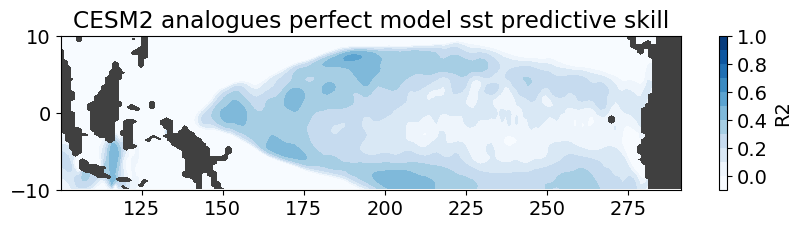

In [25]:
plt.figure(figsize=(10,2))
plt.contourf(regional_skill.TLONG,regional_skill.TLAT,np.isnan(regional_skill).astype(float),
             cmap='Greys',levels=(0.1,1.1),vmax=1.5,vmin=-3)
plt.contourf(regional_skill.TLONG,regional_skill.TLAT,regional_skill,
             levels=np.concatenate(((-2**32,),np.arange(0,1.1,0.1))),vmin=0,vmax=1,
             cmap='Blues')

plt.colorbar(label='R2')
plt.title('CESM2 analogues perfect model sst predictive skill')
plt.ylim(-10,10)